# STRIPS analysis

In this notebook we explore the performance of Fast Downward planner on STRIPS problems, comparing lazy-greedy and eager-greedy search strategies, both with additive heuristic or causal graph heuristic, or both combined.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import median
from math import sqrt
from numpy import mean
from scipy.stats import sem
from scipy.stats import t
from scipy.stats import wilcoxon
%matplotlib inline
sns.set(rc={'figure.figsize':(4,4)})
sns.set_theme(style="whitegrid")

## Preprocessing

In [2]:
df = pd.read_csv('datasets/STRIPS.csv', sep=';')
# merge columns
df['setup'] = df['search-strategy'] + ' ' + df['heuristic']
df['problem'] = df['domain'] + '-' + df['problem'].replace(' ', '_')
df['success'] = df['success (1-success, 0-failure)']
fails = len(df[df['success'] == 0])
perc_fails = fails / len(df.index) * 100
print('fails:', fails)
print('=', perc_fails, '% of', len(df.index))
# drop non-useful cols
df = df.drop(columns=['run-on', 'cost', 'solution-quality', 'coverage', '#', 'success (1-success, 0-failure)'])
df = df.dropna(subset=['generated'])
df = df[df.success == 1]
# correct types and format
df['generated'] = df['generated'].astype(int)
#df['length'] = df['length'].astype(int)
#df['peak-memory (KB)'] = df['peak-memory (KB)'].astype(int)
df['tot-time'] = df['tot-time '].str.replace('s', '').str.replace(',', '.')
df['tot-time'] = df['tot-time'].apply(lambda x: float(x))
df['search-time'] = df['search-time '].str.replace('s', '').str.replace(',', '.')
df['search-time'] = df['search-time'].apply(lambda x: float(x))
df = df.drop(columns=['tot-time ', 'search-time '])
df['%expanded'] = df['%expanded'].str.replace(',', '.').str.replace('%', '')
df['%expanded'] = df['%expanded'].apply(lambda x: float(x)/100)
df['%used'] = df['%used'].str.replace(',', '.').str.replace('%', '')
df['%used'] = df['%used'].apply(lambda x: float(x)/100)
df.head()

fails: 231
= 28.73134328358209 % of 804


,domain,problem,heuristic,search-strategy,peak-memory (KB),generated,evaluated,expanded,%expanded,length,%used,dead-ends,setup,success,tot-time,search-time
0,logistics,logistics-instance 1,add,lazy_greedy,56260.0,12282,554.0,553.0,0.0450,31.0,0.0561,0.0,lazy_greedy add,1,0.025199,0.012744
1,logistics,logistics-instance 2,add,lazy_greedy,57176.0,94273,1913.0,1912.0,0.0203,33.0,0.0173,0.0,lazy_greedy add,1,0.052168,0.044935
2,logistics,logistics-instance 3,add,lazy_greedy,70944.0,1598408,18514.0,18513.0,0.0116,62.0,0.0033,0.0,lazy_greedy add,1,0.767054,0.756947
4,logistics,logistics-instance 5,add,lazy_greedy,56260.0,21783,990.0,989.0,0.0454,27.0,0.0273,0.0,lazy_greedy add,1,0.018905,0.015498
5,logistics,logistics-instance 6,add,lazy_greedy,119716.0,7152019,9265.0,59264.0,0.0083,82.0,0.0014,0.0,lazy_greedy add,1,3.955920,3.939290


## Data Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 572 entries, 0 to 793
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   domain            572 non-null    object 
 1   problem           572 non-null    object 
 2   heuristic         572 non-null    object 
 3   search-strategy   572 non-null    object 
 4   peak-memory (KB)  572 non-null    float64
 5   generated         572 non-null    int64  
 6   evaluated         572 non-null    float64
 7   expanded          572 non-null    float64
 8   %expanded         572 non-null    float64
 9   length            571 non-null    float64
 10  %used             572 non-null    float64
 11  dead-ends         572 non-null    float64
 12  setup             572 non-null    object 
 13  success           572 non-null    int64  
 14  tot-time          572 non-null    float64
 15  search-time       572 non-null    float64
dtypes: float64(9), int64(2), object(5)
memory us

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


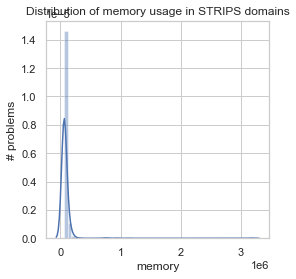

In [4]:
#plt.hist(df['peak-memory (KB)'], 50)
sns.distplot(df['peak-memory (KB)'])
plt.title('Distribution of memory usage in STRIPS domains')
plt.xlabel('memory')
plt.ylabel('# problems')
plt.show()

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


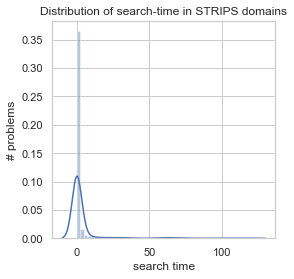

In [5]:
#plt.hist(df['search-time'], 50)
sns.distplot(df['search-time'])
plt.title('Distribution of search-time in STRIPS domains')
plt.xlabel('search time')
plt.ylabel('# problems')
plt.show()

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


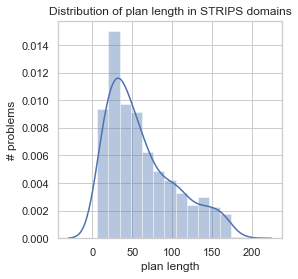

In [6]:
#plt.hist(df['search-time'], 50)
sns.distplot(df['length'])
plt.title('Distribution of plan length in STRIPS domains')
plt.xlabel('plan length')
plt.ylabel('# problems')
plt.show()

In [7]:
df['domain'].value_counts()

gripper      120
blocks       120
satelite     119
logistics    114
din phil      69
opt tel       21
psr            9
Name: domain, dtype: int64

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


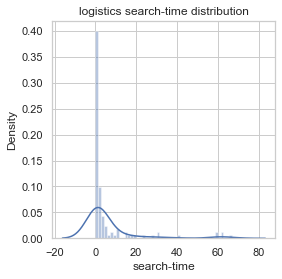

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


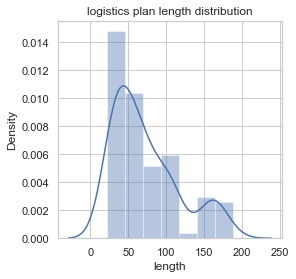

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


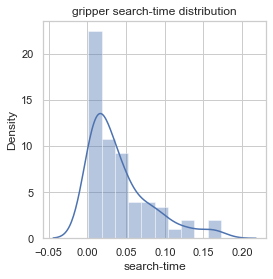

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


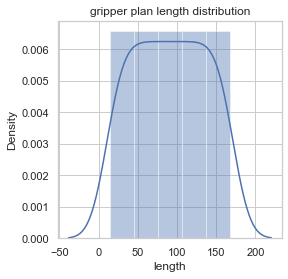

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


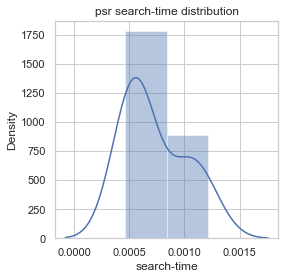

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


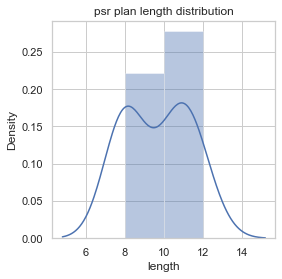

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


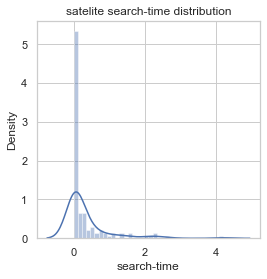

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


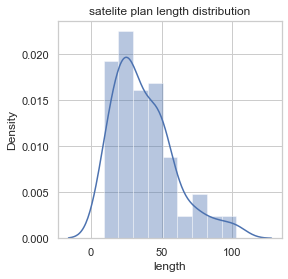

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


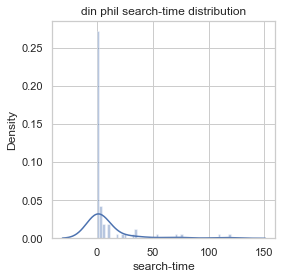

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


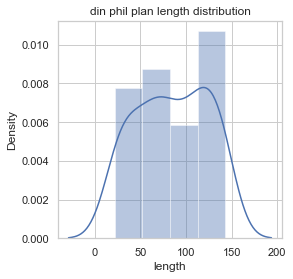

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


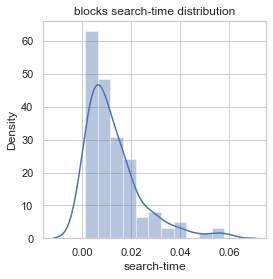

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


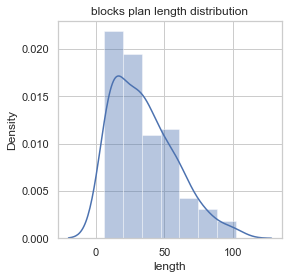

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


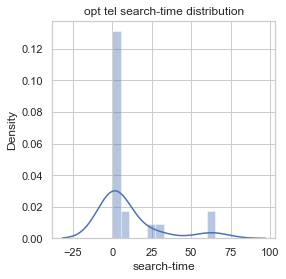

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


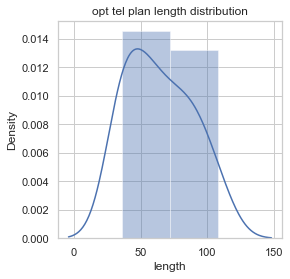

In [8]:
for domain in df['domain'].unique():
    d = df[df['domain'] == domain]
    sns.distplot(d['search-time'])
    title = domain + ' search-time distribution'
    plt.title(title)
    plt.show()
    sns.distplot(d['length'])
    title = domain + ' plan length distribution'
    plt.title(title)
    plt.show()

Only counting how many data remained after removing the unsolved, we are able to capture the most difficult domains. For all of them we ran 20 instances for each setup, except for Optical Telegraph, for which we ran only 14 problems, because the STRIPS repo contained only that number of files.
So, we conclude that Dining Philosopers, Optical Telegraph and PSR are very difficult to solve with a greedy approach and without helpful actions.

## Analysis

In [9]:
lg_add = df[df.setup == 'lazy_greedy add']
lg_cg = df[df.setup == 'lazy_greedy cg']
lg_both = df[df.setup == 'lazy_greedy add+cg']
eg_add = df[df.setup == 'eager_greedy add']
eg_cg = df[df.setup == 'eager_greedy cg']
eg_both = df[df.setup == 'eager_greedy add+cg']

### Functions

Since the complexity of the domains we considered is different, we group the visualisations into subgroups, in order to catch the details of each phenomenon. 
In addition, since some problems were solved by one heuristic but not by the other, we wondered if visualise them assigning the maximum value of the domain  + its median, in order to display them in the plot even if they miss a coordinate. This was not a good solution and generate visual confusion, so we decided to compare only the problems solved by both the compared setups

In [10]:
def get_stats(d_1, d_2):
    """
    Get the boundaries and the median of a sample
    """
    max_d1 = None
    max_d2 = None
    med_d1 = None
    med_d2 = None
    if len(d_1 > 0):
        max_d1 = d_1.max()
        med_d1 = median(d_1)
    if len(d_2 > 0):
        max_d2 = d_2.max()
        med_d2 = median(d_2)

    if max_d1 == None:
        max_d1 = max_d2
    if max_d2 == None:
        max_d2 = max_d1
        
    if med_d1 == None:
        med_d1 = med_d2
    if med_d2 == None:
        med_d2 = med_d1
        
    return {'max' : max(max_d1, max_d2), 'median' : median([med_d1, med_d2])}
        

In [11]:
def count_fails(df_1, df_2, attr, exclude=None, label_1 = 'first setup', label_2 = 'second setup'):
    """
    We count the amount of failed problems in each setup
    """
    df_1 = df_1[[attr, 'problem', 'domain']]
    df_2 = df_2[[attr, 'problem', 'domain']]
    
    #exclude domains 
    if exclude != None:
        for exc in exclude:
            df_1 = df_1[df_1['domain'] != exc]
            df_2 = df_2[df_2['domain'] != exc]
    
    p_1 = df_1.problem.unique()
    p_2 = df_2.problem.unique()
    
    unsolved_1 = 0
    unsolved_2 = 0
    
    for prob_1 in p_1:
        if prob_1 not in p_2:
            unsolved_2 += 1
    for prob_2 in p_2:
        if prob_2 not in p_1:
            unsolved_1 += 1
    return {label_1 : str('{:.2f}'.format(unsolved_1 / len(p_2)*100)) + '%',  label_2 : str('{:.2f}'.format(unsolved_2 /  len(p_1)*100)) + '%' }

In [12]:
def get_difference(df_1, df_2, attr, exclude=None, label_1 = 'first setup', label_2 = 'second setup'):
    """
    We count in how many cases first setup does better than 
    the second one and viceversa
    """
    df_1 = df_1[[attr, 'problem', 'domain']]
    df_2 = df_2[[attr, 'problem', 'domain']]
    
    #exclude domains 
    if exclude != None:
        for exc in exclude:
            df_1 = df_1[df_1['domain'] != exc]
            df_2 = df_2[df_2['domain'] != exc]
    
    p_1 = df_1.problem.unique()
    p_2 = df_2.problem.unique()
    
    better_1 = 0
    better_2 = 0
    
    for prob in p_1:
        if prob in p_2:
            if df_1.loc[df_1['problem'] == prob][attr].values[0] < df_2.loc[df_2['problem'] == prob][attr].values[0]:
                better_1 += 1
            else:
                better_2 += 1
        else:
            better_1 += 1
    for prob in p_2:
        if not prob in p_1:
            better_2 += 1
    
    title = attr + ' - ' + label_1 + ' vs ' + label_2
    sns.barplot(x=['better ' + label_1, 'better ' + label_2], y=[better_1, better_2])
    plt.title(title)
    plt.plot()

In [13]:
def plot_comparison(df_1, df_2, attr, exclude=None, label_1 = 'first setup', label_2 = 'second setup'):
    """
    Plot the performance comparison between two setups
    according to a specific attribute i.e. search-time
    """
    df_1 = df_1[[attr, 'problem', 'domain']]
    df_2 = df_2[[attr, 'problem', 'domain']]
    points = []
    seen = []
    
    for index, row in df_1.iterrows():
        datum = {}
        problem = row['problem']
        domain = row['domain']

        if len(df_2.loc[df_2['problem'] == problem][attr]) > 0:
            datum['domain'] = domain
            datum[label_1] = row[attr]
            datum[label_2] = df_2.loc[df_2['problem'] == problem][attr].values[0]
        points.append(datum)
    points = pd.DataFrame(points)

    #exclude domains 
    if exclude != None:
        for exc in exclude:
            points = points[points['domain'] != exc]
    # useful data to draw diagonal        
    max_x = points[[label_1]].max()
    max_y = points[[label_2]].max()
    max_t = max(max_x.values, max_y.values)
    
    title = attr + ' - ' + label_1 + ' vs ' + label_2
    #plot the scatter
    sc = sns.scatterplot(data=points, x=label_1, y=label_2, hue='domain', style='domain', alpha=0.5)
    sc.set(xscale='log', yscale='log')
    plt.plot([0, max_t], [0, max_t], linewidth=2)
    plt.title(title)
    plt.show()

In [14]:
def plot_comparison_tolerant(df_1, df_2, attr, exclude=None, label_1 = 'first setup', label_2 = 'second setup'):
    """
    Plot the performance comparison between two setups
    according to a specific attribute i.e. search-time
    """
    df_1 = df_1[[attr, 'problem', 'domain']]
    df_2 = df_2[[attr, 'problem', 'domain']]
    points = []
    seen = []
    
    for index, row in df_1.iterrows():
        datum = {}
        problem = row['problem']
        domain = row['domain']

        if len(df_2.loc[df_2['problem'] == problem][attr]) > 0:
            datum['domain'] = domain
            datum[label_1] = row[attr]
            datum[label_2] = df_2.loc[df_2['problem'] == problem][attr].values[0]
        else: 
            datum['domain'] = domain
            datum[label_1] = row[attr]
            stats = get_stats(df_1.loc[df_1['domain'] == domain][attr], df_2.loc[df_2['domain'] == domain][attr])
            #max values
            max_dt = stats['max']
            #find median values
            med_dt = stats['median']
            datum[label_2] = max_dt + med_dt #problem unsolved by first setup
        seen.append(row['problem'])
        points.append(datum)

    if len(df_2) > 0:
        for index, row in df_2.iterrows():
            domain = row['domain']
            datum = {}
            datum['domain'] = domain
            stats = get_stats(df_1.loc[df_1['domain'] == domain][attr], df_2.loc[df_2['domain'] == domain][attr])
            #max values
            max_dt = stats['max']
            #find median values
            med_dt = stats['median']
            datum[label_1] = max_dt + med_dt #problem unsolved by second setup
            datum[label_2] = row[attr]
            points.append(datum)
    points = pd.DataFrame(points)

    #exclude domains 
    if exclude != None:
        for exc in exclude:
            points = points[points['domain'] != exc]
    # useful data to draw diagonal        
    max_x = points[[label_1]].max()
    max_y = points[[label_2]].max()
    max_t = max(max_x.values, max_y.values)
    
    title = attr + ' - ' + label_1 + ' vs ' + label_2
    #plot the scatter
    sc = sns.scatterplot(data=points, x=label_1, y=label_2, hue='domain', style='domain', alpha=0.5)
    sc.set(xscale='log', yscale='log')
    plt.plot([0, max_t], [0, max_t], linewidth=2)
    plt.title(title)
    plt.show()

In [15]:
def wilcoxon_test(df_1, df_2, attr, exclude=None, label_1 = 'first setup', label_2 = 'second setup'):
    """
    Since we don't always have the same solved instances, 
    we have to remove the orphans and only keep the 
    problems solved by both setups
    """
    
    df_1 = df_1[[attr, 'problem', 'domain']]
    df_2 = df_2[[attr, 'problem', 'domain']]
    
    #exclude domains 
    if exclude != None:
        for exc in exclude:
            df_1 = df_1[df_1['domain'] != exc]
            df_2 = df_2[df_2['domain'] != exc]
    
    p_1 = df_1.problem.unique()
    p_2 = df_2.problem.unique()
    
    d_1 = []
    d_2 = []
    
    for prob in p_1:
        if prob in p_2:
            d_1.append(df_1.loc[df_1['problem'] == prob][attr].values[0])
            d_2.append(df_2.loc[df_2['problem'] == prob][attr].values[0])
            
    w, p = wilcoxon(d_1, d_2)
    print('w:', w, '\np:', p)
    if p > 0.05:
        print('Same distribution between', label_1, 'and', label_2, 'in terms of', attr)
    else:
        print('Significant difference between', label_1, 'and', label_2, 'in terms of', attr)

# Analysis of simple STRIPS Domains
blocks       120/120

gripper      120/120

satelite     119/120

logistics    114/120


## Comparison between heuristics
The couples of setups we compare in the next cells have constant search strategy and different heuristic

### Heuristics in lazy greedy

#### lazy greedy: add vs cg

Time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


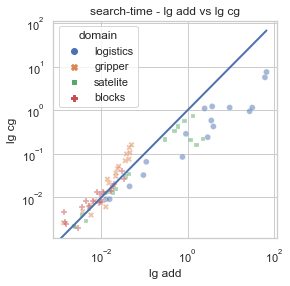

In [16]:
attr = 'search-time'
df_1 = lg_add
df_2 = lg_cg

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'lg cg')

Count of how many times one setup is better than the other

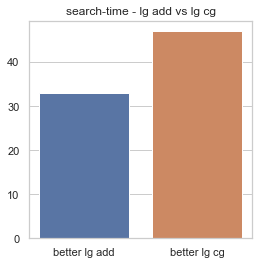

In [17]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'lg cg')

In [18]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'lg cg')

w: 941.0 
p: 0.006880402267212236
Significant difference between lg add and lg cg in terms of search-time


plan length performance

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


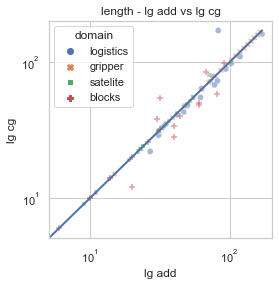

In [19]:
attr = 'length'
df_1 = lg_add
df_2 = lg_cg

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'lg cg')

In [20]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'lg cg')

w: 136.5 
p: 0.07965197378907758
Same distribution between lg add and lg cg in terms of length


Count of how many times one setup is better than the other

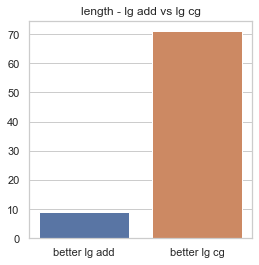

In [21]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'lg cg')

Count of failed problems for each approach

In [22]:
count_fails(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'lg cg')

{'lg add': '3.80%', 'lg cg': '1.30%'}

#### lazy greedy: add vs  both

Time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


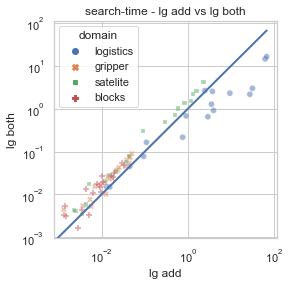

In [23]:
attr = 'search-time'
df_1 = lg_add
df_2 = lg_both

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'lg both')

Count of how many times one setup is better than the other

In [24]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'lg both')

w: 867.0 
p: 0.0012745348147303898
Significant difference between lg add and lg both in terms of search-time


plan length performance

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


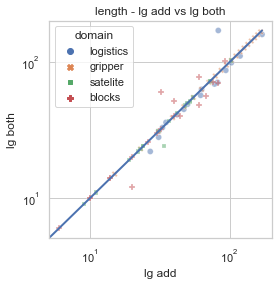

In [25]:
attr = 'length'
df_1 = lg_add
df_2 = lg_both

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'lg both')

Count of how many times one setup is better than the other

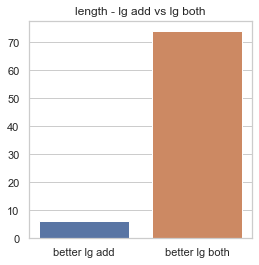

In [26]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'lg both')

In [27]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'lg both')

w: 115.5 
p: 0.12710906744516595
Same distribution between lg add and lg both in terms of length


Count of failed problems for each approach

In [28]:
count_fails(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'lg both')

{'lg add': '3.75%', 'lg both': '0.00%'}

#### Lazy greedy: cg vs both

Time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


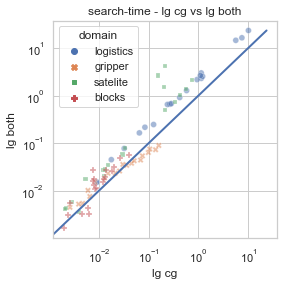

In [29]:
attr = 'search-time'
df_1 = lg_cg
df_2 = lg_both

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg cg', label_2 = 'lg both')

Count of how many times one setup is better than the other

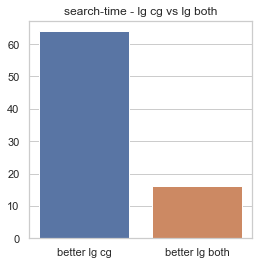

In [30]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg cg', label_2 = 'lg both')

In [31]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg cg', label_2 = 'lg both')

w: 418.0 
p: 1.3566293615948404e-08
Significant difference between lg cg and lg both in terms of search-time


plan length performance

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


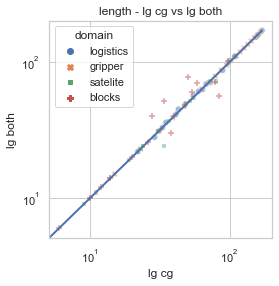

In [32]:
attr = 'length'
df_1 = lg_cg
df_2 = lg_both

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg cg', label_2 = 'lg both')

In [33]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg cg', label_2 = 'lg both')

w: 173.0 
p: 0.49106890062339426
Same distribution between lg cg and lg both in terms of length


Count of how many times one setup is better than the other

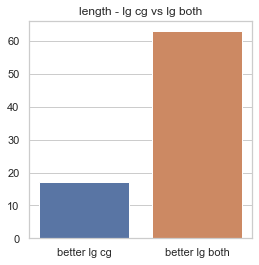

In [34]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg cg', label_2 = 'lg both')

Count of failed problems for each approach

In [35]:
count_fails(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg cg', label_2 = 'lg both')

{'lg cg': '1.25%', 'lg both': '0.00%'}

### Heuristics in eager greedy

#### eager greedy: add vs cg

Time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


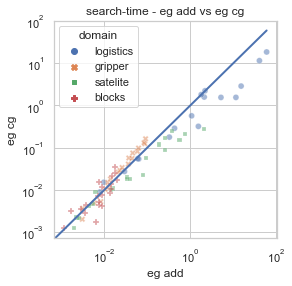

In [36]:
attr = 'search-time'
df_1 = eg_add
df_2 = eg_cg

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg add', label_2 = 'eg cg')

Count of how many times one setup is better than the other

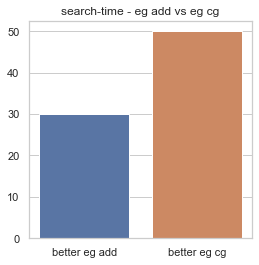

In [37]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg add', label_2 = 'eg cg')

In [38]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg add', label_2 = 'eg cg')

w: 1054.0 
p: 0.023076457378465375
Significant difference between eg add and eg cg in terms of search-time


plan length performance

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


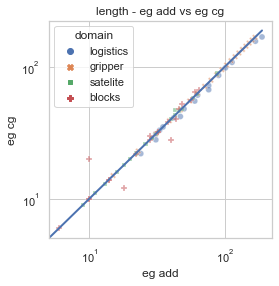

In [39]:
attr = 'length'
df_1 = eg_add
df_2 = eg_cg

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg add', label_2 = 'eg cg')

In [40]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg add', label_2 = 'eg cg')

w: 83.0 
p: 0.03191937351971746
Significant difference between eg add and eg cg in terms of length


Count of how many times one setup is better than the other

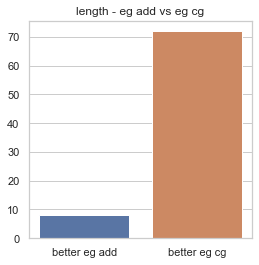

In [41]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg add', label_2 = 'eg cg')

Count of failed problems for each approach

In [42]:
count_fails(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg add', label_2 = 'eg cg')

{'eg add': '3.75%', 'eg cg': '0.00%'}

#### eager greedy: add vs  both

Time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


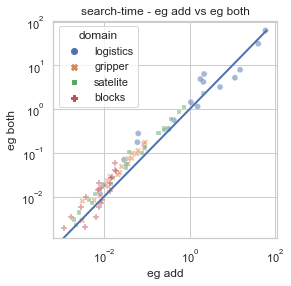

In [43]:
attr = 'search-time'
df_1 = eg_add
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg add', label_2 = 'eg both')

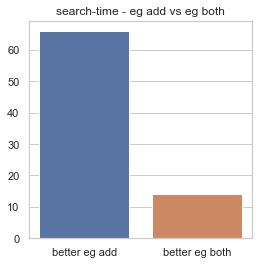

In [44]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg add', label_2 = 'eg both')

Count of how many times one setup is better than the other

In [45]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg add', label_2 = 'eg both')

w: 415.0 
p: 3.454874629316998e-08
Significant difference between eg add and eg both in terms of search-time


plan length performance

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


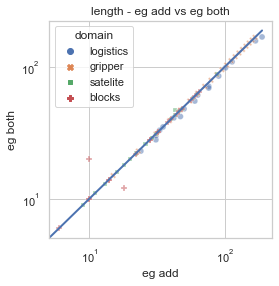

In [46]:
attr = 'length'
df_1 = eg_add
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg add', label_2 = 'eg both')

Count of how many times one setup is better than the other

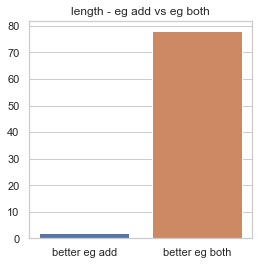

In [47]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg add', label_2 = 'eg both')

In [48]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg add', label_2 = 'eg both')

w: 24.5 
p: 0.007769140688463945
Significant difference between eg add and eg both in terms of length


Count of failed problems for each approach

In [49]:
count_fails(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg add', label_2 = 'eg both')

{'eg add': '3.75%', 'eg both': '0.00%'}

#### Eager greedy: cg vs both

Time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


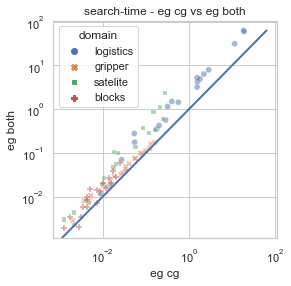

In [50]:
attr = 'search-time'
df_1 = eg_cg
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg cg', label_2 = 'eg both')

Count of how many times one setup is better than the other

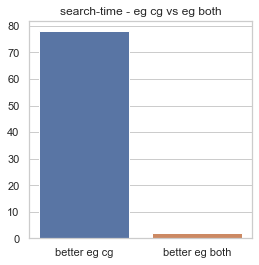

In [51]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg cg', label_2 = 'eg both')

In [52]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg cg', label_2 = 'eg both')

w: 9.0 
p: 1.1026754326146028e-14
Significant difference between eg cg and eg both in terms of search-time


plan length performance

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


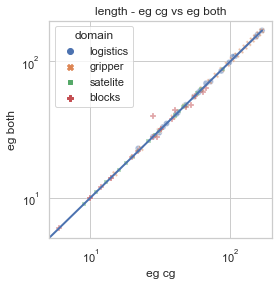

In [53]:
attr = 'length'
df_1 = eg_cg
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg cg', label_2 = 'eg both')

In [54]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg cg', label_2 = 'eg both')

w: 69.5 
p: 0.7368627580883974
Same distribution between eg cg and eg both in terms of length


Count of how many times one setup is better than the other

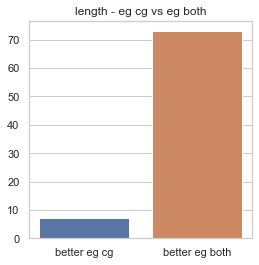

In [55]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg cg', label_2 = 'eg both')

Count of failed problems for each approach

In [56]:
count_fails(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'eg cg', label_2 = 'eg both')

{'eg cg': '0.00%', 'eg both': '0.00%'}

## Comparison between search strategies
The couples of setups we compare in the next cells have constant heuristic and different search strategy.

#### lazy greedy add vs eager greedy add

time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


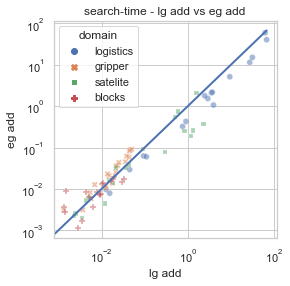

In [57]:
attr = 'search-time'
df_1 = lg_add
df_2 = eg_add

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'eg add')

Count of how many times one setup is better than the other

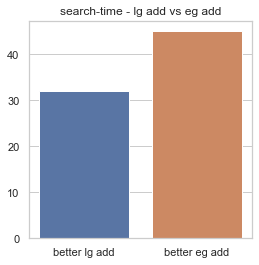

In [58]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'eg add')

In [59]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'eg add')

w: 1094.0 
p: 0.03853972533978217
Significant difference between lg add and eg add in terms of search-time


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


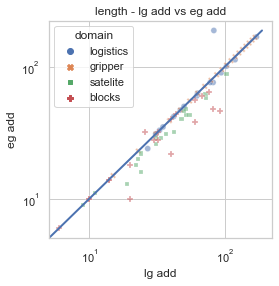

In [60]:
attr = 'length'
df_1 = lg_add
df_2 = eg_add

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'eg add')

In [61]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'eg add')

w: 60.0 
p: 3.983756183961823e-06
Significant difference between lg add and eg add in terms of length


Count of how many times one setup is better than the other

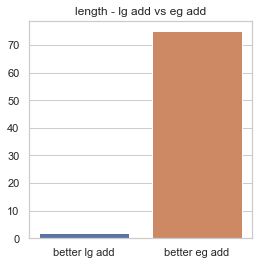

In [62]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'eg add')

In [63]:
count_fails(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'eg add')

{'lg add': '0.00%', 'eg add': '0.00%'}

#### lazy greedy cg vs eager greedy cg

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


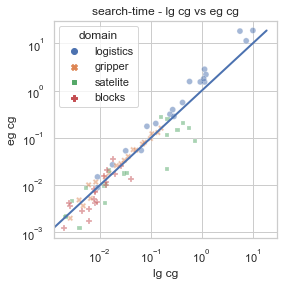

In [64]:
attr = 'search-time'
df_1 = lg_cg
df_2 = eg_cg

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg cg', label_2 = 'eg cg')

Count of how many times one setup is better than the other

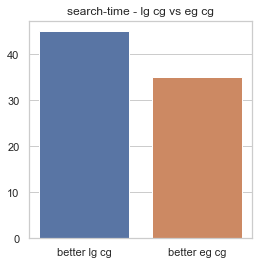

In [65]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg cg', label_2 = 'eg cg')

In [66]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg cg', label_2 = 'eg cg')

w: 1130.0 
p: 0.02786503369264474
Significant difference between lg cg and eg cg in terms of search-time


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


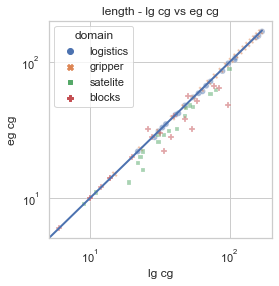

In [67]:
attr = 'length'
df_1 = lg_cg
df_2 = eg_cg

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg cg', label_2 = 'eg cg')

Count of how many times one setup is better than the other

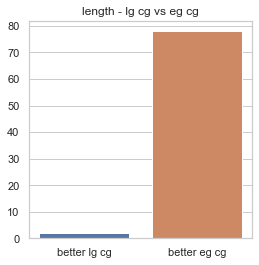

In [68]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg cg', label_2 = 'eg cg')

In [69]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add', label_2 = 'eg add')

w: 48.0 
p: 1.107379506414963e-06
Significant difference between lg add and eg add in terms of length


In [70]:
count_fails(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg cg', label_2 = 'eg cg')

{'lg cg': '1.25%', 'eg cg': '0.00%'}

#### lg both vs eg both

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


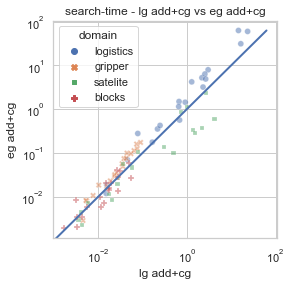

In [71]:
attr = 'search-time'
df_1 = lg_both
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add+cg', label_2 = 'eg add+cg')

Count of how many times one setup is better than the other

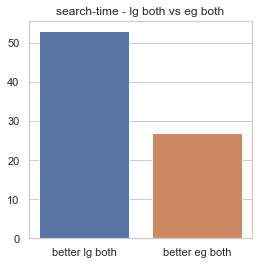

In [72]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg both', label_2 = 'eg both')

In [73]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add+cg', label_2 = 'eg add+cg')

w: 963.0 
p: 0.001626229961177956
Significant difference between lg add+cg and eg add+cg in terms of search-time


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


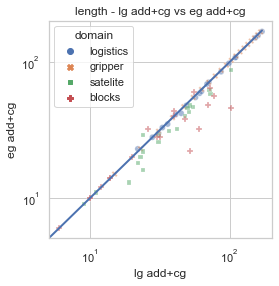

In [74]:
attr = 'length'
df_1 = lg_both
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add+cg', label_2 = 'eg add+cg')

Count of how many times one setup is better than the other

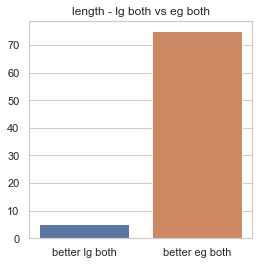

In [75]:
get_difference(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg both', label_2 = 'eg both')

In [76]:
wilcoxon_test(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg add+cg', label_2 = 'eg add+cg')

w: 103.5 
p: 2.829977289504203e-06
Significant difference between lg add+cg and eg add+cg in terms of length


In [77]:
count_fails(df_1, df_2, attr, exclude=['din phil', 'opt tel', 'psr'], label_1 = 'lg both', label_2 = 'eg both')

{'lg both': '0.00%', 'eg both': '0.00%'}

# Analysis of complex STRIPS Domains

din phil      69 / 120

opt tel       21 / 84

psr            9 / 120

## Comparison between heuristics
The couples of setups we compare in the next cells have constant search strategy and different heuristic

### Heuristics in lazy greedy

#### lazy greedy: add vs cg

Time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


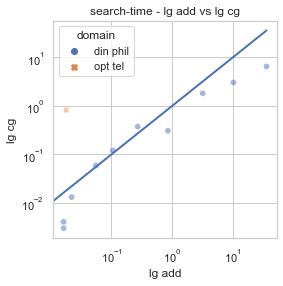

In [78]:
attr = 'search-time'
df_1 = lg_add
df_2 = lg_cg

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'lg cg')

Count of how many times one setup is better than the other

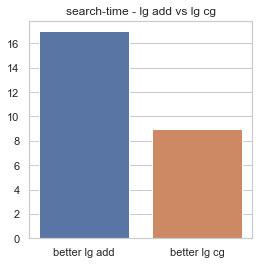

In [79]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'lg cg')

In [80]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'lg cg')

w: 20.0 
p: 0.2783203125
Same distribution between lg add and lg cg in terms of search-time


plan length performance

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


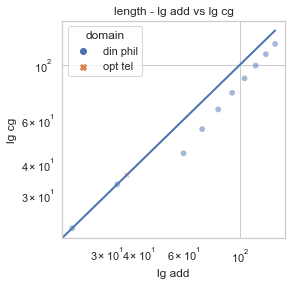

In [81]:
attr = 'length'
df_1 = lg_add
df_2 = lg_cg

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'lg cg')

In [82]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'lg cg')

w: 0.0 
p: 0.0046777349810472576
Significant difference between lg add and lg cg in terms of length


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Count of how many times one setup is better than the other

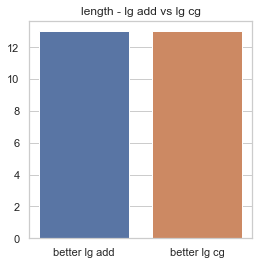

In [83]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'lg cg')

Count of failed problems for each approach

In [84]:
count_fails(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'lg cg')

{'lg add': '15.38%', 'lg cg': '54.17%'}

#### lazy greedy: add vs  both

Time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


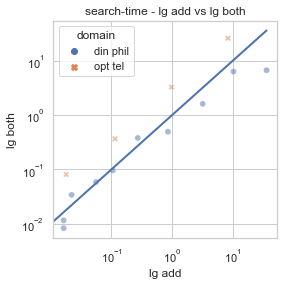

In [85]:
attr = 'search-time'
df_1 = lg_add
df_2 = lg_both

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'lg both')

Count of how many times one setup is better than the other

In [86]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'lg both')

w: 51.0 
p: 0.9515380859375
Same distribution between lg add and lg both in terms of search-time


plan length performance

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


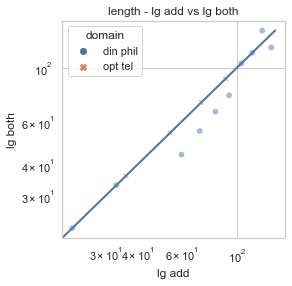

In [87]:
attr = 'length'
df_1 = lg_add
df_2 = lg_both

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'lg both')

Count of how many times one setup is better than the other

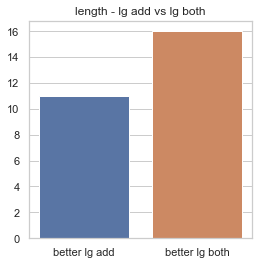

In [88]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'lg both')

In [89]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'lg both')

w: 3.5 
p: 0.10247043485974941
Same distribution between lg add and lg both in terms of length


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Count of failed problems for each approach

In [90]:
count_fails(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'lg both')

{'lg add': '17.65%', 'lg both': '41.67%'}

#### Lazy greedy: cg vs both

Time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


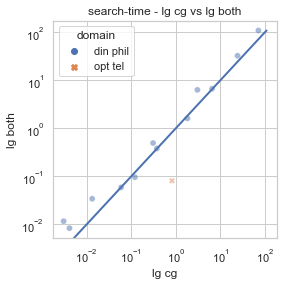

In [91]:
attr = 'search-time'
df_1 = lg_cg
df_2 = lg_both

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg cg', label_2 = 'lg both')

Count of how many times one setup is better than the other

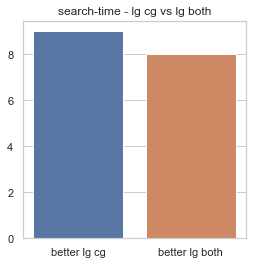

In [92]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg cg', label_2 = 'lg both')

In [93]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg cg', label_2 = 'lg both')

w: 26.0 
p: 0.19091796875
Same distribution between lg cg and lg both in terms of search-time


plan length performance

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


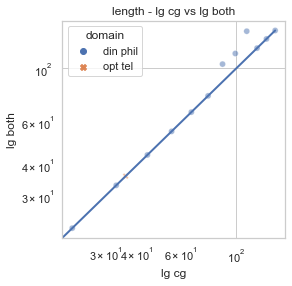

In [94]:
attr = 'length'
df_1 = lg_cg
df_2 = lg_both

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg cg', label_2 = 'lg both')

In [95]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg cg', label_2 = 'lg both')

w: 0.0 
p: 0.10247043485974937
Same distribution between lg cg and lg both in terms of length


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Count of how many times one setup is better than the other

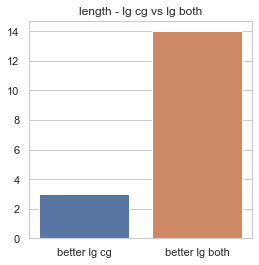

In [96]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg cg', label_2 = 'lg both')

Count of failed problems for each approach

In [97]:
count_fails(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg cg', label_2 = 'lg both')

{'lg cg': '23.53%', 'lg both': '0.00%'}

### Heuristics in eager greedy

#### eager greedy: add vs cg

Time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


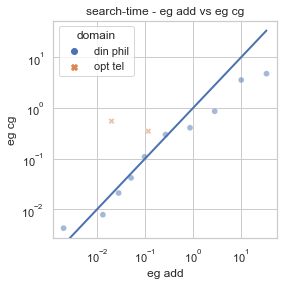

In [98]:
attr = 'search-time'
df_1 = eg_add
df_2 = eg_cg

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg add', label_2 = 'eg cg')

Count of how many times one setup is better than the other

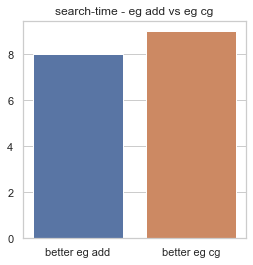

In [99]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg add', label_2 = 'eg cg')

In [100]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg add', label_2 = 'eg cg')

w: 28.0 
p: 0.423828125
Same distribution between eg add and eg cg in terms of search-time


plan length performance

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


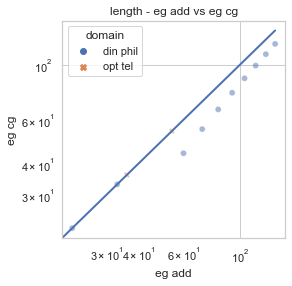

In [101]:
attr = 'length'
df_1 = eg_add
df_2 = eg_cg

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg add', label_2 = 'eg cg')

In [102]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg add', label_2 = 'eg cg')

w: 0.0 
p: 0.0046777349810472576
Significant difference between eg add and eg cg in terms of length


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Count of how many times one setup is better than the other

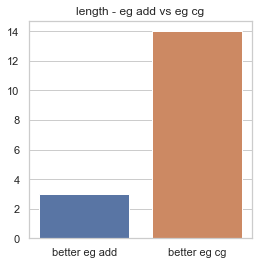

In [103]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg add', label_2 = 'eg cg')

Count of failed problems for each approach

In [104]:
count_fails(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg add', label_2 = 'eg cg')

{'eg add': '14.29%', 'eg cg': '20.00%'}

#### eager greedy: add vs  both

Time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


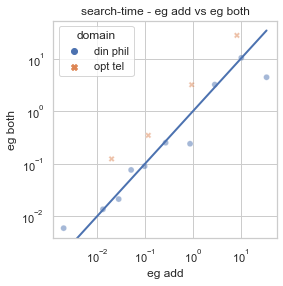

In [105]:
attr = 'search-time'
df_1 = eg_add
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg add', label_2 = 'eg both')

Count of how many times one setup is better than the other

In [106]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg add', label_2 = 'eg both')

w: 37.0 
p: 0.3575439453125
Same distribution between eg add and eg both in terms of search-time


plan length performance

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


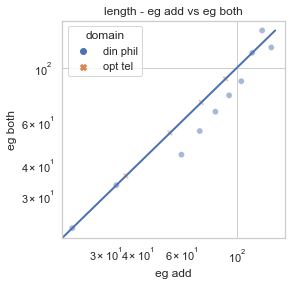

In [107]:
attr = 'length'
df_1 = eg_add
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg add', label_2 = 'eg both')

Count of how many times one setup is better than the other

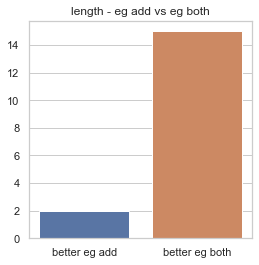

In [108]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg add', label_2 = 'eg both')

In [109]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg add', label_2 = 'eg both')

w: 4.0 
p: 0.05878172135535886
Same distribution between eg add and eg both in terms of length


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Count of failed problems for each approach

In [110]:
count_fails(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg add', label_2 = 'eg both')

{'eg add': '12.50%', 'eg both': '6.67%'}

#### Eager greedy: cg vs both

Time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


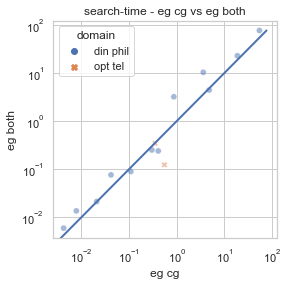

In [111]:
attr = 'search-time'
df_1 = eg_cg
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg cg', label_2 = 'eg both')

Count of how many times one setup is better than the other

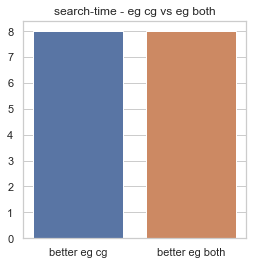

In [112]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg cg', label_2 = 'eg both')

In [113]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg cg', label_2 = 'eg both')

w: 42.0 
p: 0.5416259765625
Same distribution between eg cg and eg both in terms of search-time


plan length performance

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


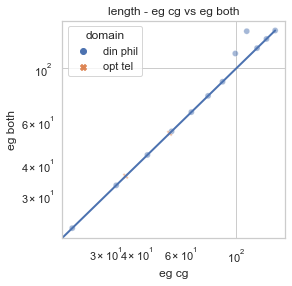

In [114]:
attr = 'length'
df_1 = eg_cg
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg cg', label_2 = 'eg both')

In [115]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg cg', label_2 = 'eg both')

w: 0.0 
p: 0.17971249487899976
Same distribution between eg cg and eg both in terms of length


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Count of how many times one setup is better than the other

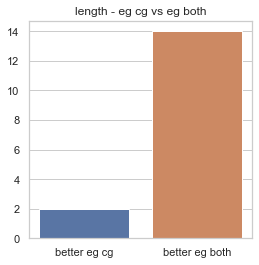

In [116]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg cg', label_2 = 'eg both')

Count of failed problems for each approach

In [117]:
count_fails(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'eg cg', label_2 = 'eg both')

{'eg cg': '12.50%', 'eg both': '0.00%'}

## Comparison between search strategies
The couples of setups we compare in the next cells have constant heuristic and different search strategy.

#### lazy greedy add vs eager greedy add

time performances

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


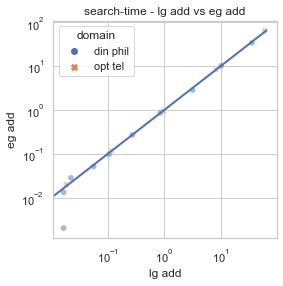

In [118]:
attr = 'search-time'
df_1 = lg_add
df_2 = eg_add

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'eg add')

Count of how many times one setup is better than the other

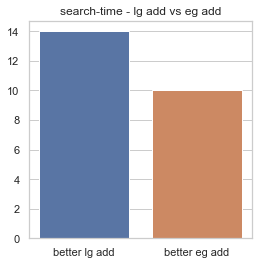

In [119]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'eg add')

In [120]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'eg add')

w: 33.0 
p: 0.1353759765625
Same distribution between lg add and eg add in terms of search-time


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


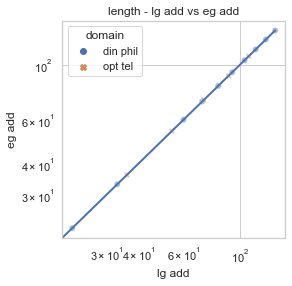

In [121]:
attr = 'length'
df_1 = lg_add
df_2 = eg_add

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'eg add')

In [122]:
try:
    wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'eg add')
except:
    print('unable to perform the test')

unable to perform the test


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Count of how many times one setup is better than the other

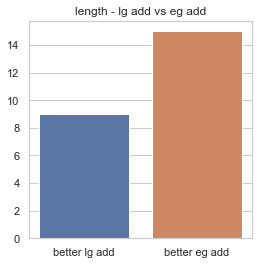

In [123]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'eg add')

In [124]:
count_fails(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'eg add')

{'lg add': '0.00%', 'eg add': '37.50%'}

#### lazy greedy cg vs eager greedy cg

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


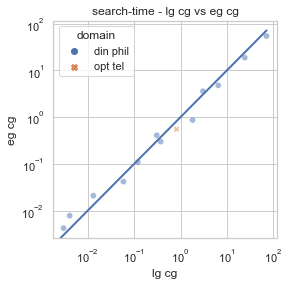

In [125]:
attr = 'search-time'
df_1 = lg_cg
df_2 = eg_cg

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg cg', label_2 = 'eg cg')

Count of how many times one setup is better than the other

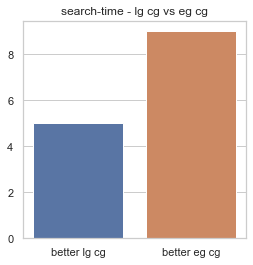

In [126]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg cg', label_2 = 'eg cg')

In [127]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg cg', label_2 = 'eg cg')

w: 22.0 
p: 0.10986328125
Same distribution between lg cg and eg cg in terms of search-time


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


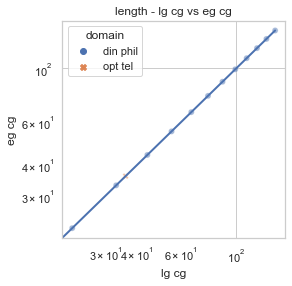

In [128]:
attr = 'length'
df_1 = lg_cg
df_2 = eg_cg

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg cg', label_2 = 'eg cg')

Count of how many times one setup is better than the other

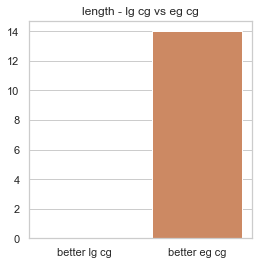

In [129]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg cg', label_2 = 'eg cg')

In [130]:
try:
    wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add', label_2 = 'eg add')
except:
    print('unable to perform the test')

unable to perform the test


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [131]:
count_fails(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg cg', label_2 = 'eg cg')

{'lg cg': '7.14%', 'eg cg': '0.00%'}

#### lg both vs eg both

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


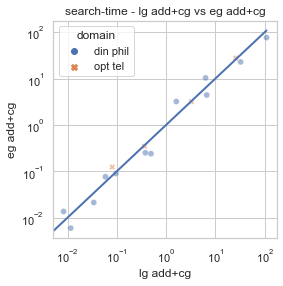

In [132]:
attr = 'search-time'
df_1 = lg_both
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add+cg', label_2 = 'eg add+cg')

Count of how many times one setup is better than the other

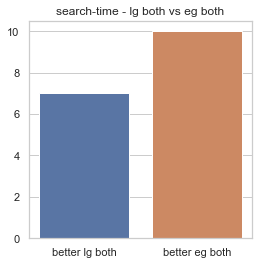

In [133]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg both', label_2 = 'eg both')

In [134]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add+cg', label_2 = 'eg add+cg')

w: 50.0 
p: 0.375457763671875
Same distribution between lg add+cg and eg add+cg in terms of search-time


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


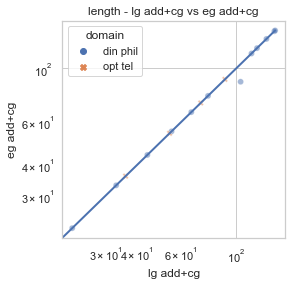

In [135]:
attr = 'length'
df_1 = lg_both
df_2 = eg_both

plot_comparison(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add+cg', label_2 = 'eg add+cg')

Count of how many times one setup is better than the other

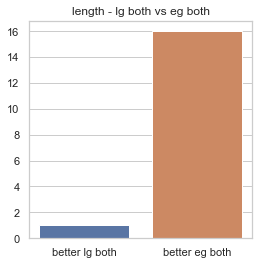

In [136]:
get_difference(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg both', label_2 = 'eg both')

In [137]:
wilcoxon_test(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg add+cg', label_2 = 'eg add+cg')

w: 0.0 
p: 0.31731050786291415
Same distribution between lg add+cg and eg add+cg in terms of length


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [138]:
count_fails(df_1, df_2, attr, exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'lg both', label_2 = 'eg both')

{'lg both': '0.00%', 'eg both': '5.88%'}

# Conclusions

## For all STRIPS

In [159]:
df_add = df[df['heuristic'] == 'add']
df_cg = df[df['heuristic'] == 'cg']
df_both = df[df['heuristic'] == 'add+cg']

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


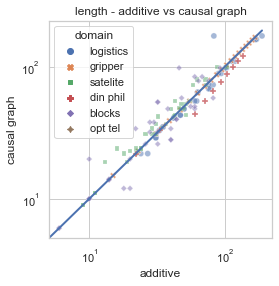

In [142]:
plot_comparison(df_add, df_cg, 'length', exclude=None, label_1 = 'additive', label_2 = 'causal graph')

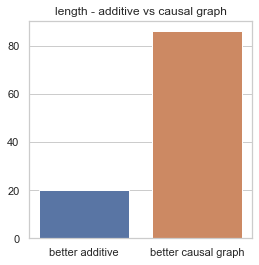

In [143]:
get_difference(df_add, df_cg, 'length', exclude=None, label_1 = 'additive', label_2 = 'causal graph')

In [144]:
count_fails(df_add, df_cg, 'length', exclude=None, label_1 = 'additive', label_2 = 'causal graph')

{'additive': '5.32%', 'causal graph': '11.88%'}

In [145]:
wilcoxon_test(df_add, df_cg, 'length', exclude=None, label_1 = 'additive', label_2 = 'causal graph')

w: 159.5 
p: 0.0021700855703648916
Significant difference between additive and causal graph in terms of length


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


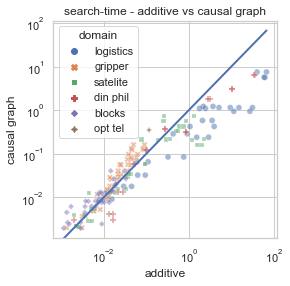

w: 1264.0 
p: 0.002515791208810005
Significant difference between additive and causal graph in terms of search-time


In [146]:
plot_comparison(df_add, df_cg, 'search-time', exclude=None, label_1 = 'additive', label_2 = 'causal graph')
wilcoxon_test(df_add, df_cg, 'search-time', exclude=None, label_1 = 'additive', label_2 = 'causal graph')

{'additive': '5.32%', 'causal graph': '11.88%'}

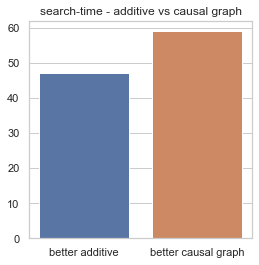

In [147]:
get_difference(df_add, df_cg, 'search-time', exclude=None, label_1 = 'additive', label_2 = 'causal graph')
count_fails(df_add, df_cg, 'search-time', exclude=None, label_1 = 'additive', label_2 = 'causal graph')

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


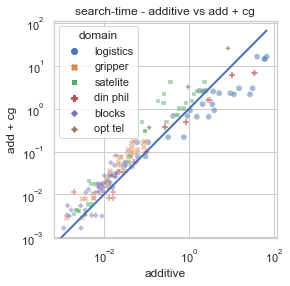

w: 1373.0 
p: 0.004376154836236264
Significant difference between additive and add + cg in terms of search-time


In [161]:
plot_comparison(df_add, df_both, 'search-time', exclude=None, label_1 = 'additive', label_2 = 'add + cg')
wilcoxon_test(df_add, df_both, 'search-time', exclude=None, label_1 = 'additive', label_2 = 'add + cg')

{'additive': '6.19%', 'add+cg': '9.90%'}

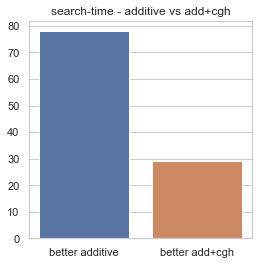

In [162]:
get_difference(df_add, df_both, 'search-time', exclude=None, label_1 = 'additive', label_2 = 'add+cg')
count_fails(df_add, df_both, 'search-time', exclude=None, label_1 = 'additive', label_2 = 'add+cg')

## For Simple STRIPS

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


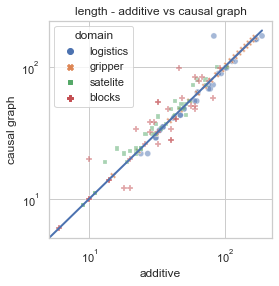

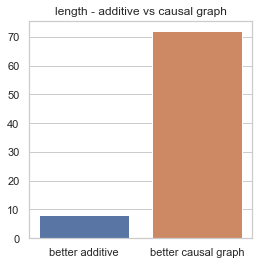

In [148]:
plot_comparison(df_add, df_cg, 'length', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'additive', label_2 = 'causal graph')
get_difference(df_add, df_cg, 'length', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'additive', label_2 = 'causal graph')

In [149]:
count_fails(df_add, df_cg, 'length', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'additive', label_2 = 'causal graph')
wilcoxon_test(df_add, df_cg, 'length', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'additive', label_2 = 'causal graph')

w: 139.5 
p: 0.05559171579053162
Same distribution between additive and causal graph in terms of length


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


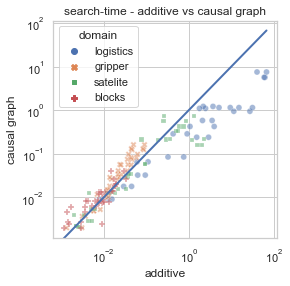

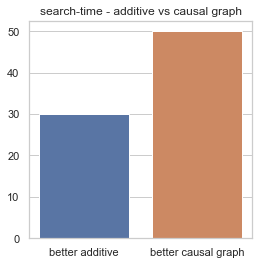

In [150]:
plot_comparison(df_add, df_cg, 'search-time', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'additive', label_2 = 'causal graph')
get_difference(df_add, df_cg, 'search-time', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'additive', label_2 = 'causal graph')

In [151]:
wilcoxon_test(df_add, df_cg, 'search-time', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'additive', label_2 = 'causal graph')

w: 932.0 
p: 0.0038326431298763308
Significant difference between additive and causal graph in terms of search-time


In [158]:
count_fails(df_add, df_cg, 'search-time', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'additive', label_2 = 'causal graph')

{'additive': '3.75%', 'causal graph': '0.00%'}

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


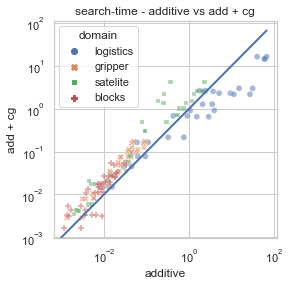

w: 845.0 
p: 0.0008580474430666793
Significant difference between additive and add + cg in terms of search-time


In [163]:
plot_comparison(df_add, df_both, 'search-time', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'additive', label_2 = 'add + cg')
wilcoxon_test(df_add, df_both, 'search-time', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'additive', label_2 = 'add + cg')

{'additive': '3.75%', 'add+cg': '0.00%'}

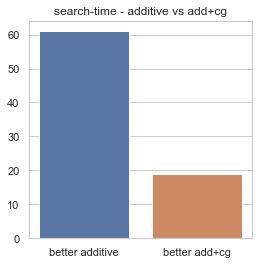

In [164]:
get_difference(df_add, df_both, 'search-time', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'additive', label_2 = 'add+cg')
count_fails(df_add, df_both, 'search-time', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'additive', label_2 = 'add+cg')

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


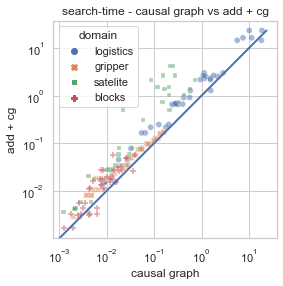

w: 27.0 
p: 2.164041722900925e-14
Significant difference between causal graph and add + cg in terms of search-time


In [165]:
plot_comparison(df_cg, df_both, 'search-time', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'causal graph', label_2 = 'add + cg')
wilcoxon_test(df_cg, df_both, 'search-time', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'causal graph', label_2 = 'add + cg')

{'causal graph': '0.00%', 'add+cg': '0.00%'}

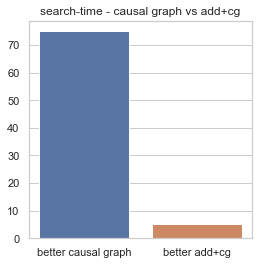

In [166]:
get_difference(df_cg, df_both, 'search-time', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'causal graph', label_2 = 'add+cg')
count_fails(df_cg, df_both, 'search-time', exclude=['din phil', 'opt tel', 'psr'], label_1 = 'causal graph', label_2 = 'add+cg')

In [167]:
df_cg['search-time'].median()

0.031263200000000005

## For complex STRIPS

/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


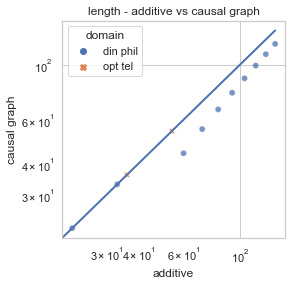

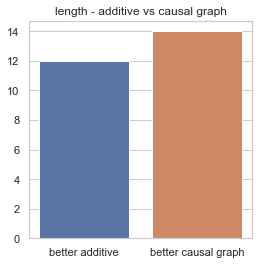

In [152]:
plot_comparison(df_add, df_cg, 'length', exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'additive', label_2 = 'causal graph')
get_difference(df_add, df_cg, 'length', exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'additive', label_2 = 'causal graph')

In [153]:
count_fails(df_add, df_cg, 'length', exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'additive', label_2 = 'causal graph')
wilcoxon_test(df_add, df_cg, 'length', exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'additive', label_2 = 'causal graph')

w: 0.0 
p: 0.0046777349810472576
Significant difference between additive and causal graph in terms of length


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


/Users/martafioravanti/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


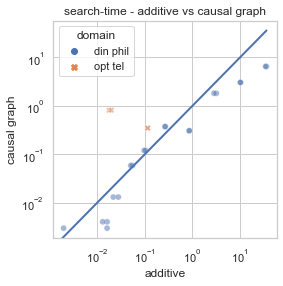

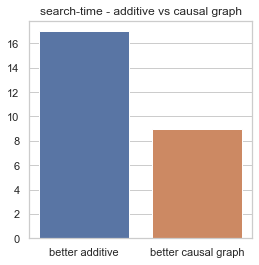

In [154]:
plot_comparison(df_add, df_cg, 'search-time', exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'additive', label_2 = 'causal graph')
get_difference(df_add, df_cg, 'search-time', exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'additive', label_2 = 'causal graph')

In [155]:
wilcoxon_test(df_add, df_cg, 'search-time', exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'additive', label_2 = 'causal graph')

w: 28.0 
p: 0.423828125
Same distribution between additive and causal graph in terms of search-time


In [157]:
count_fails(df_add, df_cg, 'search-time', exclude=['blocks', 'gripper', 'satelite', 'logistics'], label_1 = 'additive', label_2 = 'causal graph')

{'additive': '14.29%', 'causal graph': '50.00%'}